EE541 : HW 7

DATA PREPROCESSING

In [29]:
import os
import random
import shutil


# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


def extract_class_name(filename):
    if 'ethanol' in filename.lower():
        return 'ethanol'
    elif 'pentane' in filename.lower():
        return 'pentane'
    elif 'propanol' in filename.lower():
        return 'propanol'
    else:
        return None

def copy_images(source_folder, destination_folder, split, class_folder, images):
    for image in images:
        src_path = os.path.join(source_folder, class_folder, image)
        dest_path = os.path.join(destination_folder, split, class_folder, image)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copyfile(src_path, dest_path)

# Dataset organization
input_folder = 'C:\\Users\\Admin\\Downloads\\10973_2021_10903_MOESM2_ESM\\S1_Raw_Photographs_Full_Study'
output_folder = 'C:\\Users\\Admin\\Downloads\\Flame'

class_folders = ['ethanol', 'pentane', 'propanol']
for folder in class_folders:
    os.makedirs(os.path.join(output_folder, folder), exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        class_name = extract_class_name(filename)
        if class_name:
            src_path = os.path.join(input_folder, filename)
            dest_path = os.path.join(output_folder, class_name, filename)
            shutil.copyfile(src_path, dest_path)

print("Dataset extraction completed.")

# Dataset splitting
input_folder = 'C:\\Users\\Admin\\Downloads\\Flame'
output_folder = 'C:\\Users\\Admin\\Downloads\\Flame_Split'

splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(output_folder, split), exist_ok=True)

for class_folder in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_folder)
    all_images = os.listdir(class_path)
    random.shuffle(all_images)

    num_images = len(all_images)
    num_train = int(train_ratio * num_images)
    num_val = int(val_ratio * num_images)

    train_images = all_images[:num_train]
    val_images = all_images[num_train:num_train + num_val]
    test_images = all_images[num_train + num_val:]

    copy_images(input_folder, output_folder, 'train', class_folder, train_images)
    copy_images(input_folder, output_folder, 'val', class_folder, val_images)
    copy_images(input_folder, output_folder, 'test', class_folder, test_images)

print("Dataset splitting completed.")


Dataset extraction completed.
Dataset splitting completed.


Applied normmalization and/or contrast enhancement to adjust the intensity-range. Included reasonable data
augmentations such as rotations, flips, and scaling.

In [3]:
from torchvision import transforms
import os
from torchvision.datasets import ImageFolder  
from torch.utils.data import DataLoader

# Define the transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

# Apply transformations to your dataset
transformed_datasets = {split: ImageFolder(os.path.join(output_folder, split), data_transforms[split]) for split in splits}

# Create DataLoader for each split
dataloaders = {split: DataLoader(transformed_datasets[split], batch_size=32, shuffle=True) for split in splits}



MODEL

In [4]:
import torch.nn as nn
from torchvision.models import resnet34

# Define the number of burning liquid classes
num_classes = 3

# Load the pre-trained ResNet-34 model
model = resnet34(pretrained=True)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)



TRAINING

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import resnet34


# Training loop with metric recording

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Load the pretrained ResNet-34 model with modified classifier
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Freeze all layers except the fully connected classifier layer(s)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)  # Experiment with learning rates

# Training loop
num_epochs = 20  # Experiment with the number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss += loss.item()

    average_train_loss = running_loss / len(dataloaders['train'])
    accuracy_train = (correct_train / total_train) * 100

    train_losses.append(average_train_loss)
    train_accuracies.append(accuracy_train)


    print(f"Epoch [{epoch + 1}/{num_epochs}] - "
          f"Train Loss: {average_train_loss:.4f}, "
          f"Train Accuracy: {accuracy_train:.2f}%")

    # Validation loop
    model.eval()  
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in dataloaders['val']:
            outputs_val = model(inputs_val)
            loss_val = criterion(outputs_val, labels_val)

            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

            running_loss_val += loss_val.item()

    average_val_loss = running_loss_val / len(dataloaders['val'])
    accuracy_val = (correct_val / total_val) * 100

    val_losses.append(average_val_loss)
    val_accuracies.append(accuracy_val)

    print(f"Validation Loss: {average_val_loss:.4f}, "
          f"Validation Accuracy: {accuracy_val:.2f}%")



Epoch [1/20] - Train Loss: 1.1178, Train Accuracy: 37.31%
Validation Loss: 1.0410, Validation Accuracy: 46.08%
Epoch [2/20] - Train Loss: 0.9780, Train Accuracy: 52.45%
Validation Loss: 0.9359, Validation Accuracy: 60.17%
Epoch [3/20] - Train Loss: 0.8876, Train Accuracy: 61.05%
Validation Loss: 0.8513, Validation Accuracy: 67.47%
Epoch [4/20] - Train Loss: 0.8197, Train Accuracy: 65.69%
Validation Loss: 0.8072, Validation Accuracy: 71.26%
Epoch [5/20] - Train Loss: 0.7752, Train Accuracy: 68.09%
Validation Loss: 0.7577, Validation Accuracy: 71.58%
Epoch [6/20] - Train Loss: 0.7366, Train Accuracy: 70.89%
Validation Loss: 0.7244, Validation Accuracy: 74.95%
Epoch [7/20] - Train Loss: 0.7040, Train Accuracy: 71.49%
Validation Loss: 0.6916, Validation Accuracy: 77.69%
Epoch [8/20] - Train Loss: 0.6846, Train Accuracy: 73.72%
Validation Loss: 0.6680, Validation Accuracy: 76.87%
Epoch [9/20] - Train Loss: 0.6664, Train Accuracy: 74.16%
Validation Loss: 0.6561, Validation Accuracy: 76.14%
E

Plot learning and accuracy curves for the training and validation sets

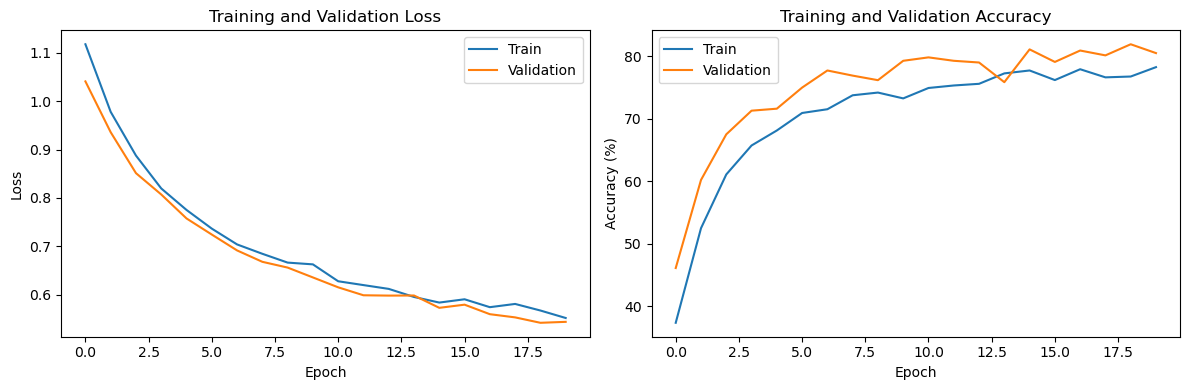

In [6]:
import matplotlib.pyplot as plt


# Rename the variables for clarity in plotting
train_loss = train_losses
train_acc = train_accuracies
val_loss = val_losses
val_acc = val_accuracies

# Plotting learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


COMMENT:  Initially, all layers of the model are frozen, except for the fully connected classifier layer. The learning rate is experimentally set to 1e-4 using the Adam optimizer. The training loop runs for 20 epochs, during which the model is set to training mode, and the training accuracy and loss are recorded. Subsequently, the model enters evaluation mode for a validation loop, where the validation accuracy and loss are computed. Notably, there are two points of interest: first, the adjustment of layer freezing to only unfreeze the fully connected layer, denoted as "Adjusted Layer Freezing"; second, an experiment with the learning rate marked as "Experiment 1: Adjusted Learning Rate," providing insights into potential hyperparameter tuning for improved model performance.

In [7]:
# Save the fine-tuned model state dictionary
torch.save(model.state_dict(), 'C:\\Users\\Admin\\Downloads\\Fine_Tune.pth')


In [8]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

LAYER VISUALIZATION

c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


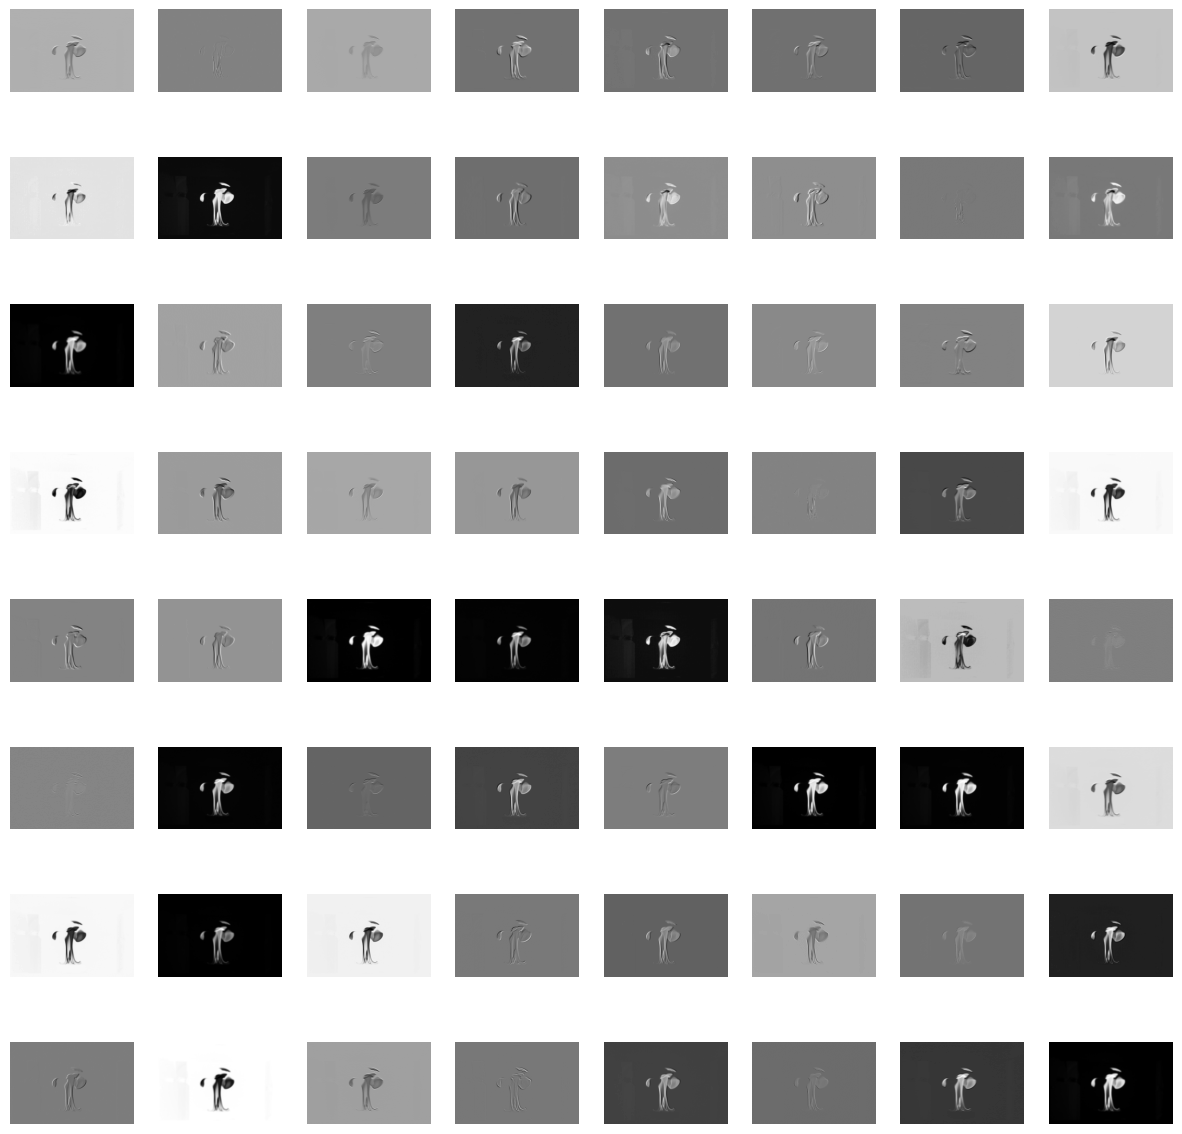

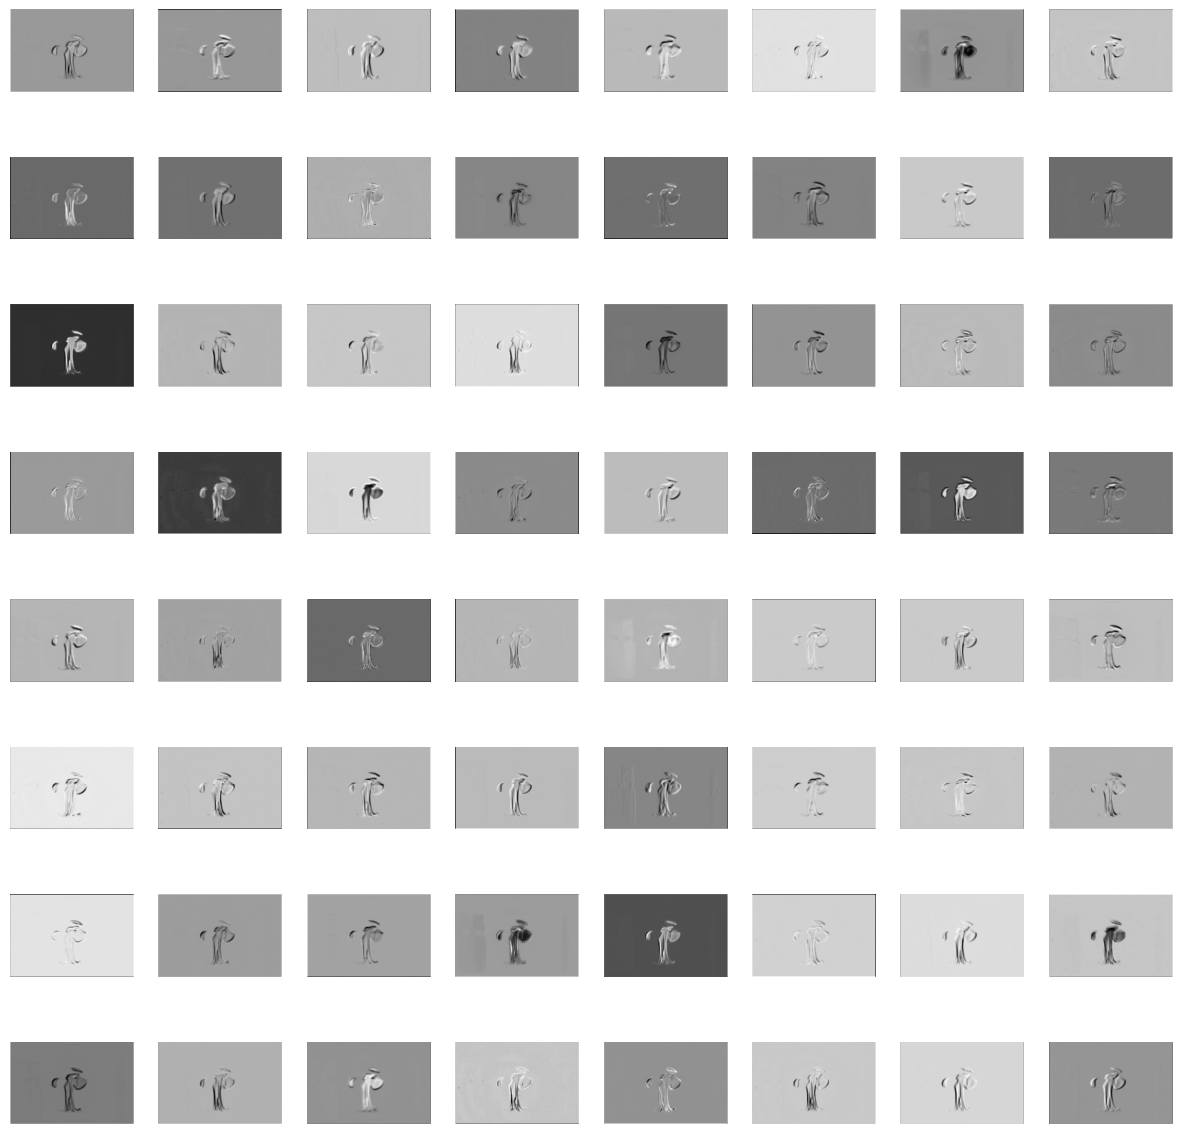

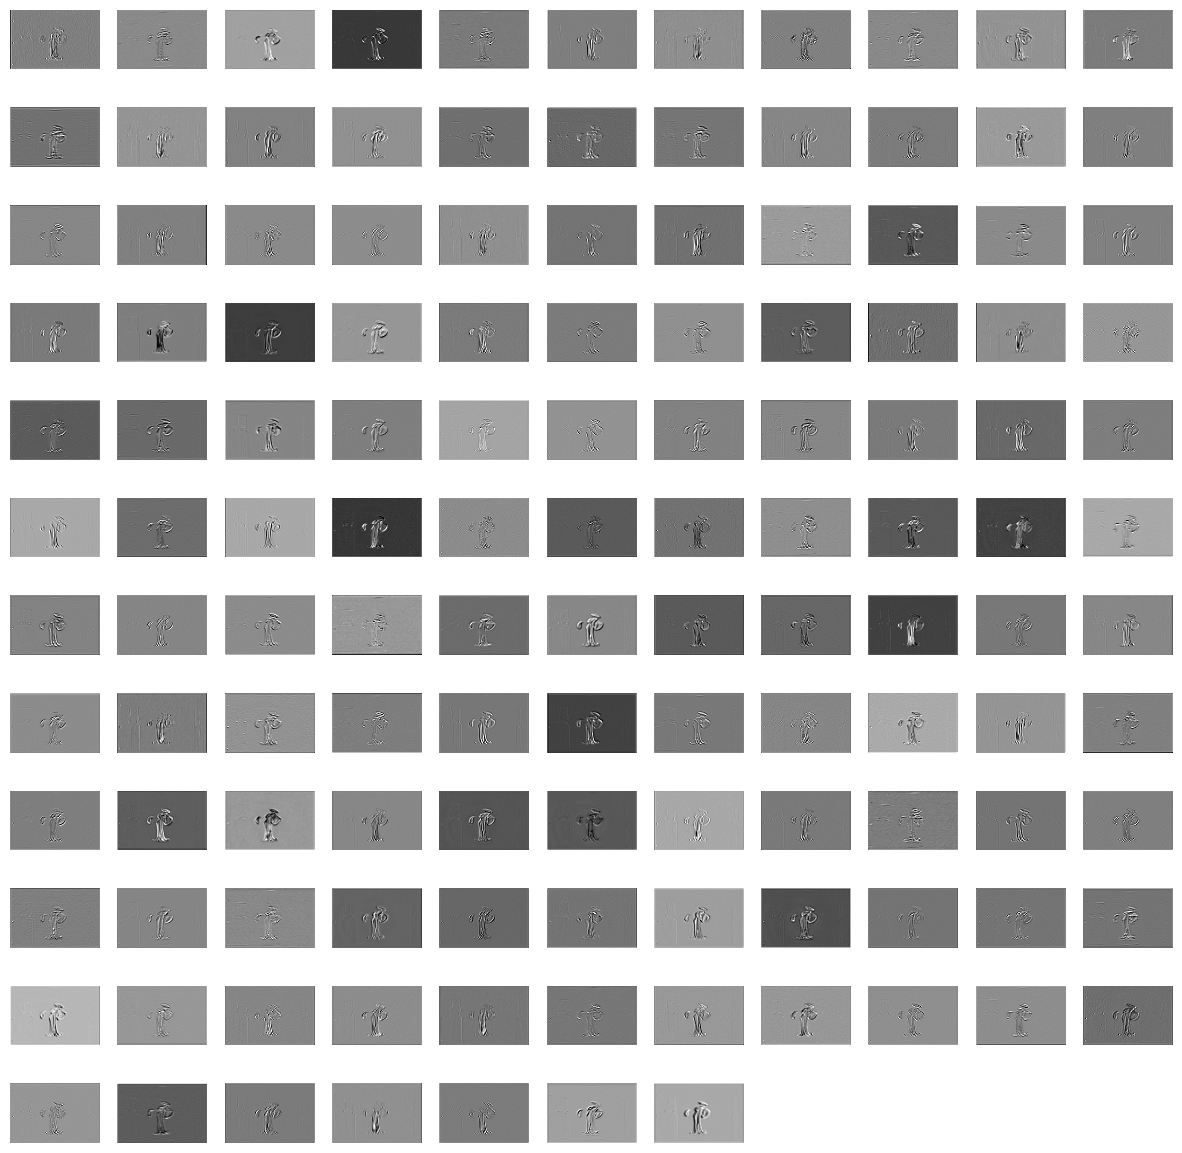

In [9]:
import math
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet34
import matplotlib.pyplot as plt


# Continue with the visualization code
model = torchvision.models.resnet34(pretrained=True)
model.eval()

# Define a hook function for visualization
def visualize_hook(module, input, output):
    num_channels = output.size(1)
    rows = math.ceil(math.sqrt(num_channels))
    cols = math.ceil(num_channels / rows)

    plt.figure(figsize=(15, 15))
    for i in range(num_channels):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

# Choose layers to visualize
layers_to_visualize = [model.conv1, model.layer1[0].conv1, model.layer2[0].conv1]

# Register hooks for the chosen layers
hooks = []
for layer in layers_to_visualize:
    hook = layer.register_forward_hook(visualize_hook)
    hooks.append(hook)


class_folder = 'ethanol'  # Change to the class you want to visualize
image_name = 'C:\\Users\\Admin\\Downloads\\Flame_Split\\train\\ethanol\\Ethanol_Full_0004.jpg'  # Change to the image you want to visualize

image_path = os.path.join(input_folder, 'train', class_folder, image_name)
image = torchvision.io.read_image(image_path).unsqueeze(0).float() / 255.0  

# Run the image through the model
_ = model(image)

# Remove the hooks
for hook in hooks:
    hook.remove()

ANALYSIS

In [10]:
import torch
import torch.nn as nn
from torchvision.models import resnet34
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load the fine-tuned model
fine_tuned_model = resnet34(pretrained=True)
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, 3)  # Replace num_classes with your actual number of classes
fine_tuned_model.load_state_dict(torch.load('C:\\Users\\Admin\\Downloads\\Fine_Tune.pth'))  # Replace with the path to your fine-tuned model
fine_tuned_model.eval()

# Define the test data transformations
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the test dataset with the same transformations
test_dataset = ImageFolder('C:\\Users\\Admin\\Downloads\\Flame_Split\\test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the fine-tuned model on the test set
correct_fine_tuned = 0
total_fine_tuned = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = fine_tuned_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_fine_tuned += labels.size(0)
        correct_fine_tuned += (predicted == labels).sum().item()

accuracy_fine_tuned = (correct_fine_tuned / total_fine_tuned) * 100
print(f"Accuracy of the fine-tuned model on the test set: {accuracy_fine_tuned:.2f}%")


Accuracy of the fine-tuned model on the test set: 79.57%


In [11]:
baseline_model = resnet34(pretrained=True)
baseline_model.fc = nn.Linear(baseline_model.fc.in_features, 3)  
baseline_model.eval()


# Define the baseline test dataset with the same transformations
baseline_test_dataset = ImageFolder('C:\\Users\\Admin\\Downloads\\Flame_Split\\test', transform=test_transform)
baseline_test_dataloader = DataLoader(baseline_test_dataset, batch_size=32, shuffle=False)

correct_baseline = 0
total_baseline = 0

with torch.no_grad():
    for inputs, labels in baseline_test_dataloader:
        outputs = baseline_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_baseline += labels.size(0)
        correct_baseline += (predicted == labels).sum().item()

accuracy_baseline = (correct_baseline / total_baseline) * 100
print(f"Accuracy of the baseline pretrained ResNet-34 model on the test set: {accuracy_baseline:.2f}%")


Accuracy of the baseline pretrained ResNet-34 model on the test set: 35.12%


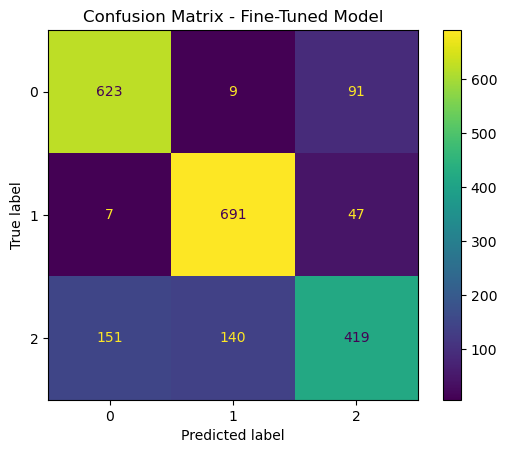

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import resnet34
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder



# Evaluate the fine-tuned model on the test set
fine_tuned_model.eval()
true_labels_fine_tuned = []
predicted_labels_fine_tuned = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = fine_tuned_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels_fine_tuned.extend(labels.numpy())
        predicted_labels_fine_tuned.extend(predicted.numpy())

# Generate confusion matrix for the fine-tuned model
conf_matrix_fine_tuned = confusion_matrix(true_labels_fine_tuned, predicted_labels_fine_tuned, labels=range(num_classes))

# Visualize confusion matrix for the fine-tuned model
disp_fine_tuned = ConfusionMatrixDisplay(conf_matrix_fine_tuned, display_labels=range(num_classes))
disp_fine_tuned.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - Fine-Tuned Model")
plt.show()



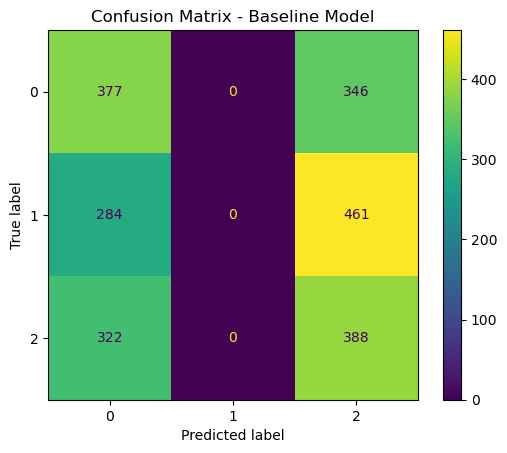

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import resnet34
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder


# Evaluate the baseline model on the test set
baseline_model.eval()
true_labels_baseline = []
predicted_labels_baseline = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = baseline_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels_baseline.extend(labels.numpy())
        predicted_labels_baseline.extend(predicted.numpy())

# Generate confusion matrix for the baseline model
conf_matrix_baseline = confusion_matrix(true_labels_baseline, predicted_labels_baseline, labels=range(num_classes))

# Visualize confusion matrix for the baseline model
disp_baseline = ConfusionMatrixDisplay(conf_matrix_baseline, display_labels=range(num_classes))
disp_baseline.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - Baseline Model")
plt.show()


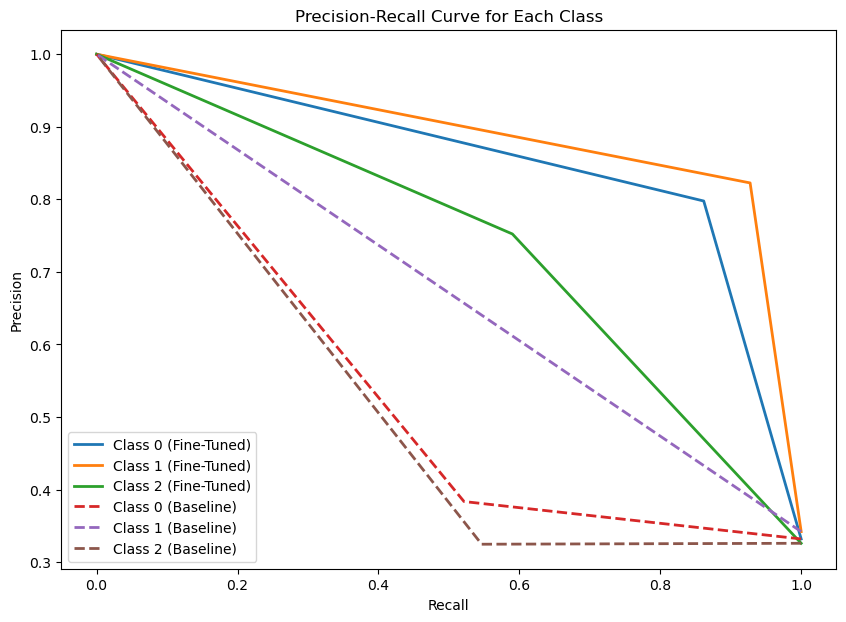

In [32]:
import torch
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Define the number of classes
num_classes = 3  

# Ensure that predicted labels are lists or arrays
predicted_labels_fine_tuned = [predicted_labels_fine_tuned] if not isinstance(predicted_labels_fine_tuned, list) else predicted_labels_fine_tuned
predicted_labels_baseline = [predicted_labels_baseline] if not isinstance(predicted_labels_baseline, list) else predicted_labels_baseline

# Binarize the true labels for each model
true_labels_fine_tuned_bin = label_binarize(true_labels_fine_tuned, classes=range(num_classes))
true_labels_baseline_bin = label_binarize(true_labels_baseline, classes=range(num_classes))

# Binarize the predicted labels for each model and each class separately
predicted_labels_fine_tuned_bin = label_binarize(predicted_labels_fine_tuned, classes=range(num_classes))
predicted_labels_baseline_bin = label_binarize(predicted_labels_baseline, classes=range(num_classes))

# Calculate precision and recall for each class
precision_fine_tuned = dict()
recall_fine_tuned = dict()
precision_baseline = dict()
recall_baseline = dict()

for i in range(num_classes):
    precision_fine_tuned[i], recall_fine_tuned[i], _ = precision_recall_curve(true_labels_fine_tuned_bin[:, i], predicted_labels_fine_tuned_bin[:, i])
    precision_baseline[i], recall_baseline[i], _ = precision_recall_curve(true_labels_baseline_bin[:, i], predicted_labels_baseline_bin[:, i])

# Plot the precision-recall curves for each class
plt.figure(figsize=(10, 7))

# Plot fine-tuned model curves
for i in range(num_classes):
    plt.plot(recall_fine_tuned[i], precision_fine_tuned[i], lw=2, label=f"Class {i} (Fine-Tuned)")

# Plot baseline model curves
for i in range(num_classes):
    plt.plot(recall_baseline[i], precision_baseline[i], lw=2, linestyle='--', label=f"Class {i} (Baseline)")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='best')
plt.show()
